In [200]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa

In [201]:
class Recuit_sem(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model,parameters):
        
        super().__init__(self,model)
        self.parameters = parameters
        self.history = []

    def execute(self):

        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _  = recuit_simule(self.model.Pool[solution_index],self.parameters['temperature_initiale'] , self.parameters['temperature_finale'],alpha=0.99)
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        
        self.execute()

In [134]:
class Tabou(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self,  model,parameters):
        super().__init__(self,model)
      
        self.parameters = parameters
        self.history = []
        self.initial_solution = None

    def execute(self):

        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _ = tabou(self.model.Pool[solution_index] ,self.parameters['taille_tabou'],self.parameters['max_iterations'],self.parameters['n_voisin'])
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        self.execute()

In [209]:
class Genetic(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self,  model,parameters):
        super().__init__(self,model)
      
        self.parameters = parameters


    def execute(self):

        new_solution, meilleure_valeur , _ ,population = genetique(self.model.Pool,self.parameters['taux_mutation'],self.parameters['max_iterations'])
        self.model.Pool = copy.deepcopy(population)

            
    def step(self):
        self.execute()

In [136]:
def compute_Pool_avg(model):
    
    couts = [cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))]
    return sum(couts)/len(couts)


def get_the_best_solution(model):

    couts = np.array([cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))])

    return model.Pool[np.argmin(couts)]

In [137]:
num_clients = nombre_client

In [210]:
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-1 } , 'tabou' : {'taille_tabou' : nombre_client , 'max_iterations' : 100 , 'n_voisin' : 2} , 'genetic'  : {'taux_mutation' : 0.5 ,'max_iterations' : 10 }}

In [212]:
class SMA(mesa.Model):
    """A model with some number of agents."""


    def __init__(self,Pool,parameters):
        
        self.schedule = mesa.time.RandomActivation(self)
        
        # solution de départ
        self.Pool = Pool
        self.history_solution = []
        # Create agents

        self.optimazers = [Recuit_sem(self,parameters['rs']),Tabou(self,parameters['tabou'])]
        self.genetique_optimizer = Genetic(self,parameters['genetic'])

        for agent in self.optimazers : 
            self.schedule.add(agent)

        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_avg": compute_Pool_avg ,"best_pool": get_the_best_solution} )


    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()
       



In [286]:
Pool = []
list_client_initial = [i for i in range(nombre_client)]
for j in range(10): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(x)

In [289]:
My_sma = SMA(Pool,parameters)

In [290]:
for i in range(200):

    My_sma.step()

    if i%10 == 1 :
        
        try :
            My_sma.genetique_optimizer.execute()
            My_sma.datacollector.collect(My_sma)

        except : 
            continue



In [300]:
My_sma.genetique_optimizer.execute()


IndexError: list index out of range

In [248]:
My_sma.datacollector.get_model_vars_dataframe()

,pool_avg,best_pool
0,28120.149544,"[520, 90, 400, 403, 364, 126, 230, 480, 367, 4..."
1,27495.161686,"[182, 312, 72, 506, 523, 467, 62, 45, 536, 322..."


In [229]:
My_sma.genetique_optimizer.execute()

In [155]:
Pop = [[i for  i in range(nombre_client)] , [num_clients-i-1 for  i in range(nombre_client)]]

In [249]:
new_solution, meilleure_valeur , _ ,population = genetique(Pool,0.01,100)


In [230]:
agent_wealth = My_sma.datacollector.get_model_vars_dataframe()

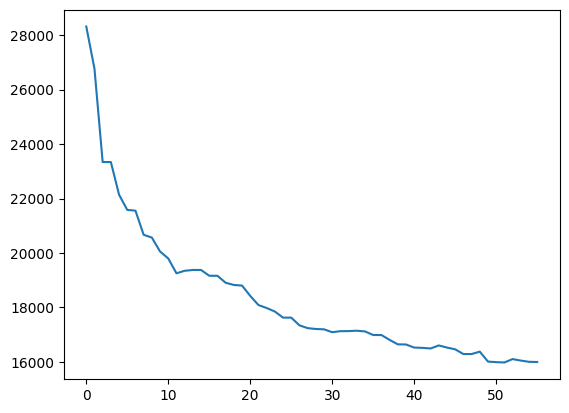

In [231]:
plt.plot(agent_wealth['pool_avg'])